![Biogeochemical Argo](https://biogeochemical-argo.org/images/logo@2x.png)

# Accessing Argo Data

---

## Overview

Building upon previous notebook, [Introduction to Argo](notebooks/argo-introduction.ipynb), we next explore how to access Argo data using various methods.

These methods are described in more detail on their respective websites, linked below. Our goal here is to provide a brief overview of some of the different tools available. 

1. [GO-BGC Toolbox](https://github.com/go-bgc/workshop-python) 
2. [Argopy](https://argopy.readthedocs.io/en/latest/user-guide/fetching-argo-data/index.html), a dedicated Python package
3. [Argovis](https://argovis.colorado.edu/argo) for API-based queries 

<!-- 2. Downloading [monthly snapshots](http://www.argodatamgt.org/Access-to-data/Argo-DOI-Digital-Object-Identifier) using Argo DOI's -->
<!-- 4. Using the [GO-BGC Toolbox](https://github.com/go-bgc/workshop-python) -->

After going through this notebook, you will be able to retrieve Argo data of interest within a certain time frame, geographical location, or by platform identifier. There are many other ways of working with Argo data, so we encourage users to explore what applications work best for their needs. 
Further information on Argo access can be found on the [Argo website](https://argo.ucsd.edu/data/).

## Prerequisites

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Numpy](https://numpy.org/learn/) | Necessary | |
| [Intro to NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Necessary | Familiarity with metadata structure |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | |

- **Time to learn**: 20 min


---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [103]:
# Import packages
import sys
import os
import numpy as np
import pandas as pd
import scipy
import xarray as xr
from datetime import datetime, timedelta

import requests
import time
import urllib3
import shutil

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from cmocean import cm as cmo

from argovisHelpers import helpers as avh

## 1. Downloading with the GO-BGC Toolbox

In the previous notebook, [Introduction to Argo](notebooks/argo-introduction.ipynb), we saw how Argo synthetic profile ('[sprof](https://archimer.ifremer.fr/doc/00445/55637/)') data is stored in netcdf4 format.

Using the GDAC function allows you to subset and download Sprof's for multiple floats. 
We recommend this tool for users who only need a few profilesd in a specific area of interest. 
Considerations: 
- Easy to use and understand
- Downloads float data as individual .nc files to your local machine (takes up storage space)
- Must download all variables available (cannot subset only variables of interest)

The two major functions below are courtesy of the [GO-BGC Toolbox](https://github.com/go-bgc/workshop-python) (Ethan Campbell). A full tutorial is available in the Toolbox.


In [104]:
# # Base filepath. Need for Argo GDAC function.z
# root = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/2024_Pythia/'
# profile_dir = root + 'SOCCOM_GO-BGC_LoResQC_LIAR_28Aug2023_netcdf/'

# # Base filepath. Need for Argo GDAC function.
root = '../data/'
profile_dir = root + 'bgc-argo/'

### 1.0 GO-BGC Toolbox Functions

In [105]:
# Function to download a single file (From GO-BGC Toolbox)
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root #profile_dir  # EDITED HERE

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [106]:
# Function to download and parse GDAC synthetic profile index file (GO-BGC Toolbox)
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (, ,
                                                            )
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

### 1.1 Using GDAC function to access Argo subsets

In [107]:
# Get all floats from chosen period
lat_bounds = [-70,-45]  # used to be -70 to -30
lon_bounds = [10,70]    # used to be 10, 60

# Try using more time buffer, 2 years. 
start_yd = datetime(2017,4,20) # datetime(2019,4,30)  
end_yd = datetime(2021,7,30) # datetime(2019,7,19)  

# dont download, just get wmoids
wmoids, gdac_index = argo_gdac(lat_range=lat_bounds,lon_range=lon_bounds,
                               start_date=start_yd,end_date=end_yd,
                               sensors=None,floats=None,
                               overwrite_index=True,overwrite_profiles=False,
                               skip_download=True,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

# download specific float #5906030 
# wmoids, gdac_index, downloaded_filenames \
#                    = argo_gdac(lat_range=None,lon_range=None,
#                                start_date=None,end_date=None,
#                                sensors=None,floats=5906030,
#                                overwrite_index=True,overwrite_profiles=False,
#                                skip_download=False,download_individual_profs=False,
#                                save_to=profile_dir,verbose=True)

>>> File argo_synthetic-profile_index.txt already exists. Overwriting with new version.
>>> Successfully downloaded argo_synthetic-profile_index.txt.


/var/folders/nt/sjynqxjj7cz9r15fkd5d4r_40000gn/T/ipykernel_89707/1987350156.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],


In [108]:
# DSdict = {}
# for filename in os.listdir(profile_dir):
#     if filename.endswith(".nc"):
#         fp = profile_dir + filename
#         single_dataset = xr.open_dataset(fp, decode_times=False)
#         DSdict[filename[0:7]] = single_dataset
# # DSdict['5906030']

## 2. Using the Argopy Python Package
argopy is a python package that facilitates access and manipulation of Argo data from all available data sources. The documentation is available [here](https://argopy.readthedocs.io/en/latest/index.html). 

The package allows you to use python to select subsets of Argo data, including data from:
* a) All available data within a "box" (geospatial area and timeframe)
* b) A specific float
* c) A specific float profile

The code here is adapted from the argopy documentation and associated examples.

### Imports

In [109]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
xr.set_options(display_expand_attrs = False)

In [110]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

### a) Fetching data for all profiles within a geographic box

Define the geographic region you want to investigate within the BOX variable:

In [111]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-56, -45, 54, 60, 0, 2000, '2022-01', '2023-01']

#### Retrieve the data:

argopy works by constructing a "Fetcher" object, named "f" here. When we define f, we specify the kinds of data we want, and also how we want to process it. 

Input arguments:
* **[ds](https://argopy.readthedocs.io/en/latest/user-guide/fetching-argo-data/data_set.html#data-set)**: specifies what Argo dataset to retrieve
   1. **"phy"**: physical Argo data (Temperature, Salinity, Pressure)
   2. **"bgc"**: biogeochemical data. Note that BGC data can only be retrieved in expert mode (real-time, no QC) as of now (2024-06-13)
* **[mode](https://argopy.readthedocs.io/en/latest/user-guide/fetching-argo-data/user_mode.html#user-mode)**: specifies the level of data QC you want
  1. **"expert"**: returns all Argo data. This is raw data with no QC or postprocessing
  2. **"standard"**: this includes real-time data that has undergone automated QC and is probably good quality, but has not been checked by a human
  3. **"resesarch"**: this is the most trustworthy data, and only includes delayed mode data that has undergone QC and and been checked by a human expert
* **parallel**: if True, parallelizes the data retrieval process to speed it up
* **progress**: if True, will display a progress bar of data retrieval
* **cache**: I'm not sure what this does
* **chunks_maxsize**: specifies how to chunk the data request into smaller domains

Once "f" is defined, we can specify f.region(BOX) and load our data.


#### Construct a fetcher object

In [112]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='research', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset () ...


/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimens

CPU times: user 11.2 s, sys: 1.52 s, total: 12.7 s
Wall time: 17.6 s


<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for a space/time region
API: https://erddap.ifremer.fr/erddap
Domain: [x=-56.00/-45.00; y=54.00/60.0 ... 00.0; t=2022-01-01/2023-01-01]
Performances: cache=False, parallel=True
User mode: research
Dataset: phy

#### Extract the data from the fetcher object**

Once the data is loaded, we can [extract our data as an xarray dataset](https://argopy.readthedocs.io/en/latest/user-guide/working-with-argo-data/data_manipulation.html). Using f.data, the default output is a 1D array of all measurements across all profiles. 

In [113]:
ds_points = f.data

In [114]:
ds_points

<xarray.Dataset> Size: 18MB
Dimensions:          (N_POINTS: 233340)
Coordinates:
  * N_POINTS         (N_POINTS) int64 2MB 0 1 2 3 ... 233337 233338 233339
    LATITUDE         (N_POINTS) float64 2MB 59.68 59.68 59.68 ... 57.29 57.29
    LONGITUDE        (N_POINTS) float64 2MB -54.96 -54.96 ... -51.58 -51.58
    TIME             (N_POINTS) datetime64[ns] 2MB 2022-01-01T01:12:00 ... 20...
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 2MB 129 129 129 129 129 ... 29 29 29 29 29
    DIRECTION        (N_POINTS) <U1 933kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 2MB 6902751 6902751 ... 6904231 6904231
    PRES             (N_POINTS) float32 933kB 3.0 4.0 ... 1.977e+03 1.981e+03
    PRES_ERROR       (N_POINTS) float32 933kB 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4
    PSAL             (N_POINTS) float32 933kB 34.52 34.51 34.51 ... 34.9 34.9
    PSAL_ERROR       (N_POINTS) float32 933kB 0.01 0.01 0.01 ... 0.01 0.01 0.01
    TEMP             (N_POINTS) float32 933kB 3.816 3.824 3.827 ... 3.479 3.478
    TEMP_ERROR       (N_POINTS) float32 933kB 0.002 0.002 0.002 ... 0.002 0.002
Attributes: (8)

**Converting to a 2D array of profiles**

Using the [dataset.argo.point2profile()](https://argopy.readthedocs.io/en/latest/generated/xarray.Dataset.argo.point2profile.html#xarray.Dataset.argo.point2profile) method, we can turn the 1d array into a 2D array, grouped by individual profiles. 

Note that each N_PROF is unique, although the dataset does not include identifying metadata for the profiles, such as WMO number.

In [115]:
ds_profiles = ds_points.argo.point2profile();

/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


In [116]:
ds_profiles

<xarray.Dataset> Size: 10MB
Dimensions:          (N_PROF: 497, N_LEVELS: 1016)
Coordinates:
  * N_PROF           (N_PROF) int64 4kB 81 479 18 58 480 ... 253 131 390 161 478
  * N_LEVELS         (N_LEVELS) int64 8kB 0 1 2 3 4 ... 1011 1012 1013 1014 1015
    LATITUDE         (N_PROF) float64 4kB 59.68 55.46 56.85 ... 58.59 57.29
    LONGITUDE        (N_PROF) float64 4kB -54.96 -47.06 -49.92 ... -50.91 -51.58
    TIME             (N_PROF) datetime64[ns] 4kB 2022-01-01T01:12:00 ... 2022...
Data variables:
    CYCLE_NUMBER     (N_PROF) int64 4kB 129 70 205 274 71 ... 86 164 168 159 29
    DIRECTION        (N_PROF) <U1 2kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 4kB 6902751 7900589 ... 6902786 6904231
    PRES             (N_PROF, N_LEVELS) float32 2MB 3.0 4.0 5.0 ... nan nan nan
    PRES_ERROR       (N_PROF, N_LEVELS) float32 2MB 2.4 2.4 2.4 ... nan nan nan
    PSAL             (N_PROF, N_LEVELS) float32 2MB 34.52 34.51 ... nan nan
    PSAL_ERROR       (N_PROF, N_LEVELS) float32 2MB 0.01 0.01 0.01 ... nan nan
    TEMP             (N_PROF, N_LEVELS) float32 2MB 3.816 3.824 ... nan nan
    TEMP_ERROR       (N_PROF) float32 2kB 0.002 0.002 0.002 ... 0.002 0.002
Attributes: (8)

#### Extract float metadata from the fetcher object
Float metadata, including the float's unique WMO number, and each profile's cycle number, are retrieved as a pandas dataframe using f.index

In [117]:
f.index

,date,latitude,longitude,wmo,cyc
0,2022-10-19 10:44:00,57.657937,-48.629002,6904231,18
1,2022-10-17 12:58:00,57.658190,-48.705695,6904231,17
2,2022-10-16 13:03:00,57.703905,-48.804165,6904231,16
3,2022-10-15 13:06:00,57.765147,-48.940843,6904231,15
4,2022-10-14 12:53:00,57.828338,-49.130402,6904231,14
...,...,...,...,...,...
492,2022-03-17 11:39:36,54.478210,-45.868540,7900589,88
493,2022-03-22 11:52:50,54.376430,-45.618210,7900589,89
494,2022-03-27 12:02:29,54.397450,-45.479260,7900589,90
495,2022-04-01 11:59:34,54.197520,-46.080610,7900589,91


#### Basic data visualization
argopy includes some [built-in data visualization functions](https://argopy.readthedocs.io/en/latest/user-guide/working-with-argo-data/visualisation.html#)

Here is the default map function, which plots each float's trajectory, colored by the float.

/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/plot/plot.py:409: UserWarning: More than one N_LEVELS found in this dataset, scatter_map will use the first level only
  warnings.warn("More than one N_LEVELS found in this dataset, scatter_map will use the first level only")


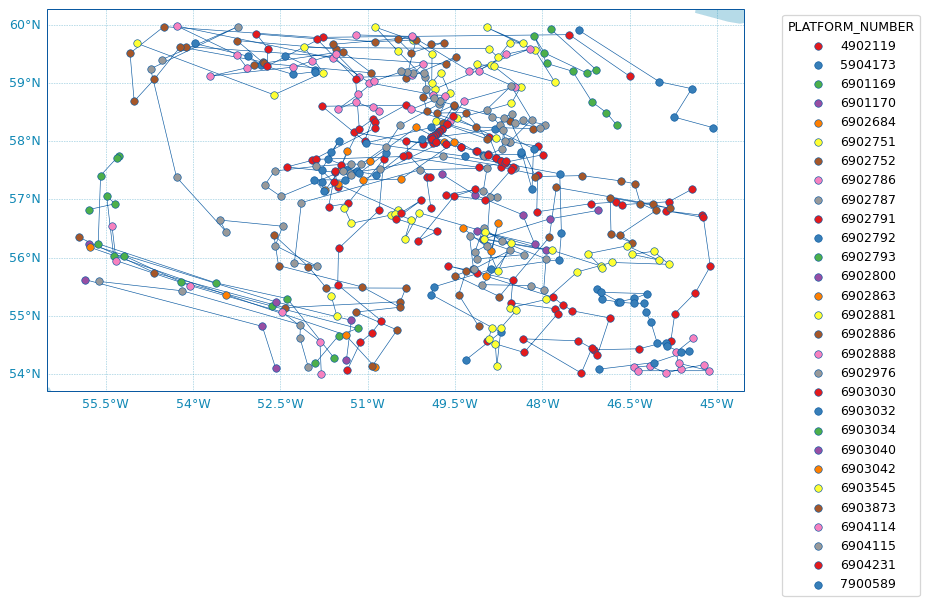

In [118]:
scatter_map(ds_profiles);

We can also zoom out and see where the data globally

/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/plot/plot.py:409: UserWarning: More than one N_LEVELS found in this dataset, scatter_map will use the first level only
  warnings.warn("More than one N_LEVELS found in this dataset, scatter_map will use the first level only")


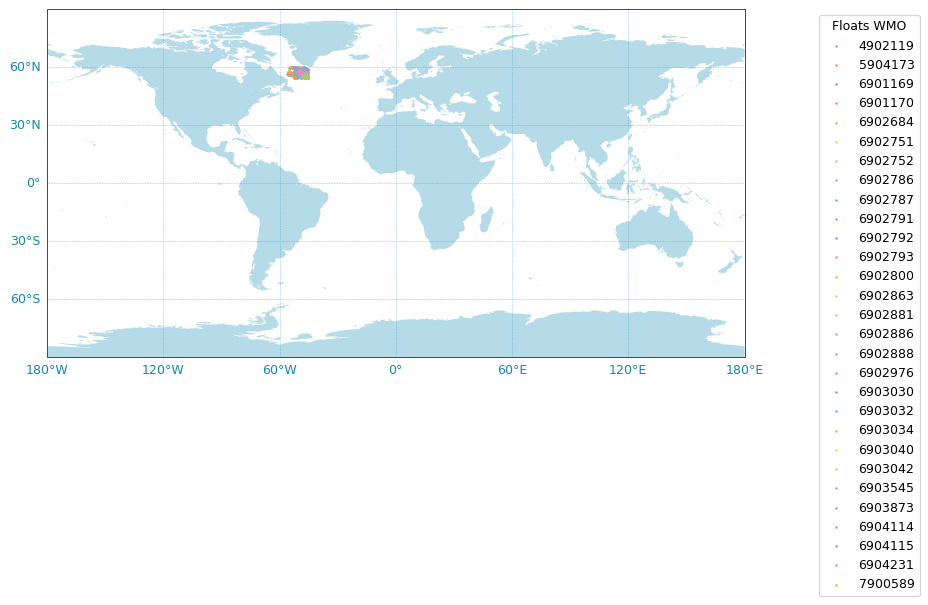

In [119]:
fig, ax = scatter_map(ds_profiles,
                   figsize=(10,6),
                   set_global=True,
                   markersize=2,
                   markeredgecolor=None,
                   legend_title='Floats WMO',
                   cmap='Set2')

### b) Fetching data for a specific float(s)
This works much the same as the example above. However, instead of requesting a BOX with spatiotemporal bounds, we request a specific float by its unique WMO number. For multiple floats, simply pass a list of WMO numbers

In [120]:
%%time
f = DataFetcher(ds='phy', mode='research', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )

# We use the f.float() method to fetch data from a specific float (using its WMO#, here 5904673)
# To request multiple floats, simply pass a list of multiple WMO numbers, e.g. [5904673, 5904672]
f = f.float(5904673).load();
f

Final post-processing of the merged dataset () ...


/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimens

CPU times: user 1.23 s, sys: 80.1 ms, total: 1.31 s
Wall time: 4.98 s


<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for floats
API: https://erddap.ifremer.fr/erddap
Domain: WMO5904673
Performances: cache=False, parallel=True
User mode: research
Dataset: phy

#### Extracting and manipulating the data
As before, we extract the data as a 1D array of measurements in xarray, and convert that into a 2D array of profiles using ds.argo.point2profile()

In [121]:
ds_points = f.data
ds_profiles = ds_points.argo.point2profile();

/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


#### Visualizing the data
This float is from the Southern Ocean's Pacific sector

/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/plot/plot.py:409: UserWarning: More than one N_LEVELS found in this dataset, scatter_map will use the first level only
  warnings.warn("More than one N_LEVELS found in this dataset, scatter_map will use the first level only")


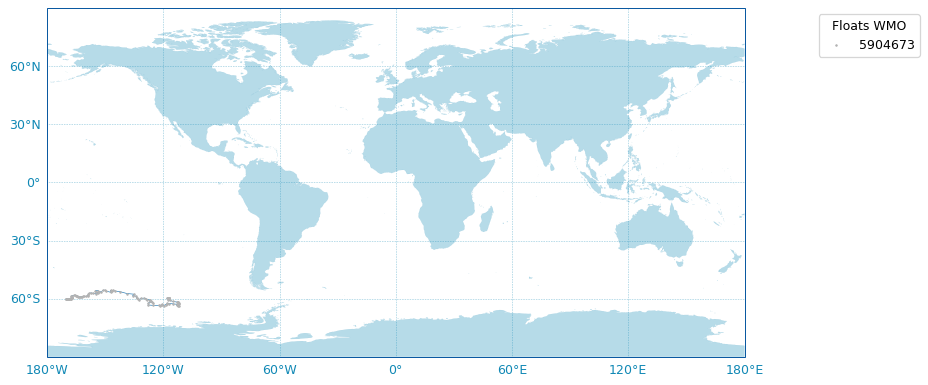

In [122]:
fig, ax = scatter_map(ds_profiles,
                   figsize=(10,6),
                   set_global=True,
                   markersize=2,
                   markeredgecolor=None,
                   legend_title='Floats WMO',
                   cmap='Set2')

Now let's plot the float's temperature profiles over its trajectory

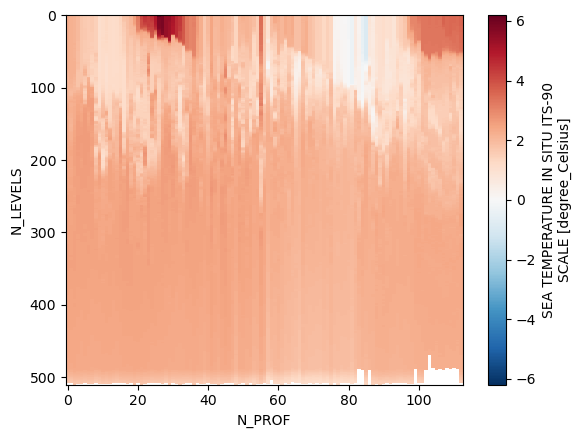

In [123]:
# We use xarray's built-in plotting function on the temperature data array
# We transpose it so that the vertical dimension (N_LEVELS) is on the y-axis
ds_profiles.TEMP.transpose().plot() 
plt.gca().invert_yaxis() # Invert the y-axis so the ocean's surface is at the top

### c) Fetching data for a specific float profile(s)
Let's narrow it down even further, and request a single profile using the fetcher's f.profile() method, and passing the float's unique WMO number and the profile number. 
To request multiple profiles, simply pass a list of profile numbers

In [124]:
%%time
f = DataFetcher(ds='phy', mode='research', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )

# We use the f.profile() method to fetch data from a specific profile using the float WMO number and profile number
# To request multiple profiles, simply pass a list of multiple profile numbers, e.g. (5904673,[1,2,3])
f = f.profile(5904673,30).load();
f

Final post-processing of the merged dataset () ...
CPU times: user 180 ms, sys: 13.9 ms, total: 194 ms
Wall time: 925 ms


/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimens

<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for profiles
API: https://erddap.ifremer.fr/erddap
Domain: WMO5904673_CYC30
Performances: cache=False, parallel=True
User mode: research
Dataset: phy

#### Extracting and manipulating the data
Once again, we extract the data as a 1D array of measurements in xarray, and convert that into a 2D array of profiles using ds.argo.point2profile()

In [125]:
ds_points = f.data
ds_profiles = ds_points.argo.point2profile();

/opt/homebrew/Caskroom/mambaforge/base/envs/sklearn-argo-dev/lib/python3.9/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


#### Visualizing the data
Let's plot the vertical temperature and salinity profiles

Text(0.5, 1.0, 'Temperature profile: Float 5904673, Profile 30')

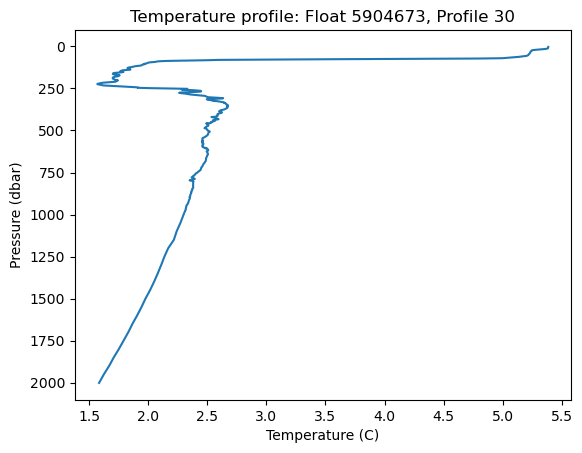

In [126]:
plt.plot(ds_profiles.sel(N_PROF=0).TEMP.data,ds_profiles.sel(N_PROF=0).PRES.data) # Plot Temperature versus Pressure (i.e. depth)
plt.gca().invert_yaxis() # Invert the axis to put the surface at the top
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (dbar)')
plt.title('Temperature profile: Float 5904673, Profile 30')


Text(0.5, 1.0, 'Salinity profile: Float 5904673, Profile 30')

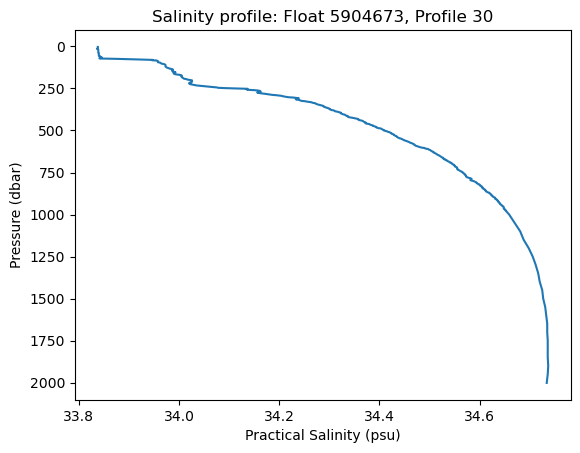

In [127]:
plt.plot(ds_profiles.sel(N_PROF=0).PSAL.data,ds_profiles.sel(N_PROF=0).PRES.data) # Plot Temperature versus Pressure (i.e. depth)
plt.gca().invert_yaxis() # Invert the axis to put the surface at the top
plt.xlabel('Practical Salinity (psu)')
plt.ylabel('Pressure (dbar)')
plt.title('Salinity profile: Float 5904673, Profile 30')


## 3. Querying Data with Argovis

Argovis provides an API that allows us to interact with Argo data while only downloading the exact subsets of data needed for analysis. 
Our examples here are modified from the [tutorial notebooks](https://github.com/argovis/demo_notebooks) released by Argovis. We showcase only a few of the functionalities, but more information can be found in the previous link.

The introduction published by Argovis:
>"Argovis is a REST API and web application for searching, downloading, co-locating and visualizing oceanographic data, including Argo array data, ship-based profile data, data from the Global Drifter Program, tropical cyclone data, and several gridded products. Our API is meant to be integrated into living documents like Jupyter notebooks and analyses intended to update their consumption of Argo data in near-real-time, and our web frontend is intended to make it easy for students and educators to explore data about Earth's oceans at will."

Argovis should be cited as:

Tucker, T., D. Giglio, M. Scanderbeg, and S.S.P. Shen: Argovis: A Web Application for Fast Delivery, Visualization, and Analysis of Argo Data. J. Atmos. Oceanic Technol., 37, 401–416, https://doi.org/10.1175/JTECH-D-19-0041.1


### Getting started with `argovisHelpers`

From the Argovis tutorial: 
> In order to allocate Argovis's limited computing resources fairly, users are encouraged to register and request a free API key. This works like a password that identifies your requests to Argovis. To do so:
>
> - Visit [https://argovis-keygen.colorado.edu/](https://argovis-keygen.colorado.edu/)
> - Fill out the form under _New Account Registration_
> - An API key will be emailed to you shortly.
>
> Treat this API key like a password - don't share it or leave it anywhere public. If you ever forget it or accidentally reveal it to a third party, see the same website above to change or deactivate your token.
>
> Put your API key in the quotes in the variable below before moving on:

In [128]:
API_ROOT='https://argovis-api.colorado.edu/'
API_KEY='de6ee72a54bc5ca29dee5c801cab13fa4a354985'

### Getting Argo data documents

Before actually getting Argo measurements, we can query information about the profile (including pointers to the metadata).

In [129]:
argoSearch = {
    'startDate': '2013-05-01T00:00:00Z',
    'endDate': '2023-05-01T00:00:00Z',
    'center': '-22.5,0',
    'radius': 100
}

argoProfiles = avh.query('argo', options=argoSearch, apikey=API_KEY, apiroot=API_ROOT)
argoProfiles[0]

{'_id': '1901820_256',
 'geolocation': {'type': 'Point', 'coordinates': [-22.75594, -0.2218]},
 'basin': 1,
 'timestamp': '2023-04-09T18:34:30.001Z',
 'date_updated_argovis': '2023-07-14T10:44:14.125Z',
 'source': [{'source': ['argo_core'],
   'url': 'ftp://ftp.ifremer.fr/ifremer/argo/dac/aoml/1901820/profiles/R1901820_256.nc',
   'date_updated': '2023-07-13T22:33:14.000Z'}],
 'cycle_number': 256,
 'geolocation_argoqc': 1,
 'profile_direction': 'A',
 'timestamp_argoqc': 1,
 'vertical_sampling_scheme': 'Primary sampling: averaged [nominal 2 dbar binned data sampled at 0.5 Hz from a SBE41CP]',
 'data_info': [['pressure',
   'pressure_argoqc',
   'salinity',
   'salinity_argoqc',
   'temperature',
   'temperature_argoqc'],
  ['units', 'data_keys_mode'],
  [['decibar', 'A'],
   [None, None],
   ['psu', 'A'],
   [None, None],
   ['degree_Celsius', 'A'],
   [None, None]]],
 'metadata': ['1901820_m0']}

In [130]:
argoProfiles[0]['_id']

'1901820_256'

Note that the first object in argoProfiles is a single vertical Argo "profile". 
The first 7 digits of `argoProfiles[0]['_id']` refer to a float's WMO unique identification number. 
The last three digits are the profile number. 

In the above example, we are looking at data from the 256th profile from float WMO #1901820.

We can get more information about this particular float by querying `argo/meta`.

In [131]:
metaOptions = {
    'id': argoProfiles[0]['metadata'][0]
}
argoMeta = avh.query('argo/meta', options=metaOptions, apikey=API_KEY, apiroot=API_ROOT)
argoMeta

[{'_id': '1901820_m0',
  'data_type': 'oceanicProfile',
  'data_center': 'AO',
  'instrument': 'profiling_float',
  'pi_name': ['BRECK OWENS', ' STEVEN JAYNE', ' P.E. ROBBINS'],
  'platform': '1901820',
  'platform_type': 'S2A',
  'fleetmonitoring': 'https://fleetmonitoring.euro-argo.eu/float/1901820',
  'oceanops': 'https://www.ocean-ops.org/board/wa/Platform?ref=1901820',
  'positioning_system': 'GPS',
  'wmo_inst_type': '854'}]

We can also specify all of the profiles taken from the same float with WMO ID 1901820.

In [132]:
platformSearch = {
    'platform': argoMeta[0]['platform']
}

platformProfiles = avh.query('argo', options=platformSearch, apikey=API_KEY, apiroot=API_ROOT)
print(len(platformProfiles))

301


### Making `data` queries

Now, we want to retrieve actual measurements. We can use any number of identifiers. 

Below, we are specifying float WMO 4901283 and profile #003. The `data` variable can be:

- A comma separated list of variable names, e.g. `'temperature, doxy'`
- `'all'`, meaning get all available variables. 

In [133]:
dataQuery = {
    'id': '4901283_003',
    'data': 'all'
}
profile = avh.query('argo', options=dataQuery, apikey=API_KEY, apiroot=API_ROOT)
# avh.data_inflate(profile[0])[0:10]

We can query float profiles within larger bounds: 

In [134]:
dataQuery = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2024-01-01T00:00:00Z',
    'polygon': [[-150,-30],[-155,-30],[-155,-35],[-150,-35],[-150,-30]],
    'data': 'doxy'
}

profiles = avh.query('argo', options=dataQuery, apikey=API_KEY, apiroot=API_ROOT)

In [135]:
inflated_data = avh.data_inflate(profiles[0])
inflated_data[0:10]

[{'doxy': 241.201248, 'pressure': 2.11},
 {'doxy': 241.218338, 'pressure': 3.91},
 {'doxy': 241.165558, 'pressure': 5.91},
 {'doxy': 241.141434, 'pressure': 7.91},
 {'doxy': 241.180618, 'pressure': 9.91},
 {'doxy': 241.151245, 'pressure': 11.91},
 {'doxy': 241.115402, 'pressure': 13.91},
 {'doxy': 241.214294, 'pressure': 15.91},
 {'doxy': 241.186188, 'pressure': 17.91},
 {'doxy': 241.199326, 'pressure': 19.91}]

### Querying within geospatial bounds

In [136]:
qs = {
    'startDate': '2017-08-01T00:00:00Z',
    'endDate': '2017-09-01T00:00:00Z',
    'box': [[-20,70],[20,72]]
}

profiles = avh.query('argo', options=qs, apikey=API_KEY, apiroot=API_ROOT)
latitudes = [x['geolocation']['coordinates'][1] for x in profiles]
print(min(latitudes))
print(max(latitudes))

70.017
71.957


### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!